# Lab 5: Xây dựng mô hình RNN cho bài toán Nhận dạng Thực thể Tên (NER)

## Mục tiêu
- Tải và tiền xử lý dữ liệu NER từ CoNLL 2003
- Xây dựng từ điển cho từ và nhãn NER
- Tạo Dataset và DataLoader trong PyTorch
- Xây dựng mô hình RNN
- Huấn luyện và đánh giá mô hình

## Import thư viện

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from collections import Counter
from tqdm import tqdm
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Task 1: Tải và Tiền xử lý Dữ liệu

### 1.1 Tải dữ liệu từ Hugging Face

In [11]:
dataset = load_dataset("conll2003", revision="refs/convert/parquet")

print(f"\nCác split: {dataset.keys()}")
print(f"Số câu train: {len(dataset['train'])}")
print(f"Số câu validation: {len(dataset['validation'])}")
print(f"Số câu test: {len(dataset['test'])}")


Các split: dict_keys(['train', 'validation', 'test'])
Số câu train: 14041
Số câu validation: 3250
Số câu test: 3453


### 1.2 Trích xuất câu và nhãn

In [13]:
# Trích xuất tokens và tags
train_sentences = dataset["train"]["tokens"]
train_tags = dataset["train"]["ner_tags"]

val_sentences = dataset["validation"]["tokens"]
val_tags = dataset["validation"]["ner_tags"]

test_sentences = dataset["test"]["tokens"]
test_tags = dataset["test"]["ner_tags"]

# Lấy ánh xạ từ số sang tên nhãn
tag_names = dataset["train"].features["ner_tags"].feature.names
print(f"\nDanh sách nhãn NER: {tag_names}")

# Chuyển đổi tags từ số sang string
def convert_tags_to_strings(tags_list, tag_names):
    return [[tag_names[tag] for tag in tags] for tags in tags_list]

train_tags_str = convert_tags_to_strings(train_tags, tag_names)
val_tags_str = convert_tags_to_strings(val_tags, tag_names)
test_tags_str = convert_tags_to_strings(test_tags, tag_names)

print(f"\nVí dụ câu đầu tiên:")
print(f"Tokens: {train_sentences[0]}")
print(f"Tags: {train_tags_str[0]}")


Danh sách nhãn NER: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Ví dụ câu đầu tiên:
Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Tags: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


### 1.3 Xây dựng Từ điển

In [15]:
# Xây dựng word_to_ix
word_to_ix = {"<PAD>": 0, "<UNK>": 1}
for sentence in train_sentences:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

# Xây dựng tag_to_ix
tag_to_ix = {"<PAD>": 0}  # Padding tag
for tag in tag_names:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

# Tạo ix_to_tag để decode predictions
ix_to_tag = {v: k for k, v in tag_to_ix.items()}

print(f"\nKích thước từ điển:")
print(f"Số từ (word_to_ix): {len(word_to_ix)}")
print(f"Số nhãn (tag_to_ix): {len(tag_to_ix)}")
print(f"\nTag mapping: {tag_to_ix}")


Kích thước từ điển:
Số từ (word_to_ix): 23625
Số nhãn (tag_to_ix): 10

Tag mapping: {'<PAD>': 0, 'O': 1, 'B-PER': 2, 'I-PER': 3, 'B-ORG': 4, 'I-ORG': 5, 'B-LOC': 6, 'I-LOC': 7, 'B-MISC': 8, 'I-MISC': 9}


## Task 2: Tạo PyTorch Dataset và DataLoader

### 2.1 Tạo lớp NERDataset

In [18]:
class NERDataset(Dataset):
    def __init__(self, sentences, tags, word_to_ix, tag_to_ix):
        self.sentences = sentences
        self.tags = tags
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]
        
        # Convert words to indices
        sentence_indices = torch.tensor(
            [self.word_to_ix.get(word, self.word_to_ix["<UNK>"]) for word in sentence],
            dtype=torch.long
        )
        
        # Convert tags to indices
        tag_indices = torch.tensor(
            [self.tag_to_ix[tag] for tag in tags],
            dtype=torch.long
        )
        
        return sentence_indices, tag_indices

train_dataset = NERDataset(train_sentences, train_tags_str, word_to_ix, tag_to_ix)
val_dataset = NERDataset(val_sentences, val_tags_str, word_to_ix, tag_to_ix)
test_dataset = NERDataset(test_sentences, test_tags_str, word_to_ix, tag_to_ix)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 14041
Validation dataset size: 3250
Test dataset size: 3453


### 2.2 Tạo collate function và DataLoader

In [23]:
def collate_fn(batch):
    sentences, tags = zip(*batch)
    
    # Pad sequences
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word_to_ix["<PAD>"])
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=tag_to_ix["<PAD>"])
    
    return sentences_padded, tags_padded

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Số batch trong tập train: {len(train_loader)}")
print(f"Số batch trong tập validation: {len(val_loader)}")

sample_batch = next(iter(train_loader))
print(f"\nShape của batch đầu tiên:")
print(f"Sentences shape: {sample_batch[0].shape}")
print(f"Tags shape: {sample_batch[1].shape}")

Số batch trong tập train: 439
Số batch trong tập validation: 102

Shape của batch đầu tiên:
Sentences shape: torch.Size([32, 43])
Tags shape: torch.Size([32, 43])


## Task 3: Xây dựng Mô hình RNN

### 3.1 Định nghĩa SimpleRNNForTokenClassification

In [26]:
class SimpleRNNForTokenClassification(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, padding_idx=0, num_layers=1):
        super(SimpleRNNForTokenClassification, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                          batch_first=True, bidirectional=True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, sentences):
        embeds = self.embedding(sentences)
        embeds = self.dropout(embeds)
        
        rnn_out, _ = self.rnn(embeds)
        rnn_out = self.dropout(rnn_out)
        
        output = self.fc(rnn_out)
        
        return output

EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 2

model = SimpleRNNForTokenClassification(
    vocab_size=len(word_to_ix),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_size=len(tag_to_ix),
    padding_idx=word_to_ix["<PAD>"],
    num_layers=NUM_LAYERS
)

print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTổng số parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

SimpleRNNForTokenClassification(
  (embedding): Embedding(23625, 100, padding_idx=0)
  (rnn): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Tổng số parameters: 2,995,854
Trainable parameters: 2,995,854


## Task 4: Huấn luyện Mô hình

### 4.1 Khởi tạo optimizer và loss function

In [29]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Found {device}")

model = model.to(device)

# Loss function - ignore padding index
criterion = nn.CrossEntropyLoss(ignore_index=tag_to_ix["<PAD>"])

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"Loss function: CrossEntropyLoss (ignore_index={tag_to_ix['<PAD>']})")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Scheduler: ReduceLROnPlateau")

Found cuda
Loss function: CrossEntropyLoss (ignore_index=0)
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau


### 4.2 Viết vòng lặp huấn luyện

In [30]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for sentences, tags in tqdm(dataloader, desc="Training"):
        sentences = sentences.to(device)
        tags = tags.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(sentences)  # (batch_size, seq_len, num_tags)
        
        outputs_flat = outputs.view(-1, outputs.shape[-1])  # (batch_size * seq_len, num_tags)
        tags_flat = tags.view(-1)
        
        loss = criterion(outputs_flat, tags_flat)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for sentences, tags in tqdm(dataloader, desc="Evaluating"):
            sentences = sentences.to(device)
            tags = tags.to(device)
            
            outputs = model(sentences)
            
            outputs_flat = outputs.view(-1, outputs.shape[-1])
            tags_flat = tags.view(-1)
            
            loss = criterion(outputs_flat, tags_flat)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

### 4.3 Huấn luyện mô hình

In [32]:
NUM_EPOCHS = 5
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Training starting")

for epoch in range(NUM_EPOCHS):
    print(f"\n[Epoch {epoch + 1}/{NUM_EPOCHS}]")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Evaluate
    val_loss = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"\nTrain Loss: {train_loss:.3f}")
    print(f"Val Loss: {val_loss:.3f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_ner_model.pt')
        print("Saved best model")

print(f"Best validation loss: {best_val_loss:.3f}")

Training starting

[Epoch 1/5]


Evaluating: 100%|██████████| 102/102 [00:00<00:00, 112.62it/s]



Train Loss: 0.170
Val Loss: 0.187
Saved best model

[Epoch 2/5]


Evaluating: 100%|██████████| 102/102 [00:00<00:00, 110.95it/s]



Train Loss: 0.133
Val Loss: 0.169
Saved best model

[Epoch 3/5]


Evaluating: 100%|██████████| 102/102 [00:00<00:00, 110.35it/s]



Train Loss: 0.111
Val Loss: 0.170

[Epoch 4/5]


Evaluating: 100%|██████████| 102/102 [00:00<00:00, 111.78it/s]



Train Loss: 0.092
Val Loss: 0.155
Saved best model

[Epoch 5/5]


Evaluating: 100%|██████████| 102/102 [00:01<00:00, 77.31it/s]


Train Loss: 0.078
Val Loss: 0.171
Best validation loss: 0.155


### 4.4 Vẽ đồ thị loss

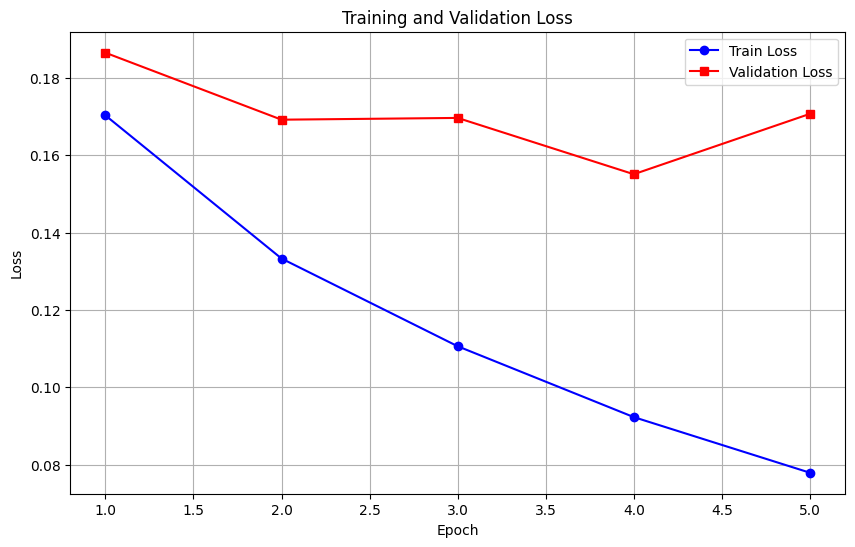

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', label='Train Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, 'r-', label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Task 5: Đánh giá Mô hình

### 5.1 Tính accuracy trên validation set

In [34]:
def calculate_accuracy(model, dataloader, device, tag_to_ix):
    model.eval()
    correct = 0
    total = 0
    
    pad_idx = tag_to_ix["<PAD>"]
    
    with torch.no_grad():
        for sentences, tags in tqdm(dataloader, desc="Calculating accuracy"):
            sentences = sentences.to(device)
            tags = tags.to(device)
            
            outputs = model(sentences)  # (batch_size, seq_len, num_tags)
            
            predictions = torch.argmax(outputs, dim=-1)  # (batch_size, seq_len)
            
            mask = (tags != pad_idx)
            
            correct += ((predictions == tags) & mask).sum().item()
            total += mask.sum().item()
    
    accuracy = correct / total if total > 0 else 0
    return accuracy

model.load_state_dict(torch.load('best_ner_model.pt'))

val_accuracy = calculate_accuracy(model, val_loader, device, tag_to_ix)
print(f"Accuracy on validation dataset: {val_accuracy:.3f} ({val_accuracy*100:.2f}%)")

Calculating accuracy: 100%|██████████| 102/102 [00:01<00:00, 92.26it/s]

Accuracy on validation dataset: 0.956 (95.64%)


### 5.2 Tính F1-score chi tiết cho từng loại thực thể (Nâng cao)


In [ ]:
def get_predictions_and_labels(model, dataloader, device, tag_to_ix, ix_to_tag):
    """
    Get all predictions and true labels
    """
    model.eval()
    all_predictions = []
    all_labels = []
    
    pad_idx = tag_to_ix["<PAD>"]
    
    with torch.no_grad():
        for sentences, tags in tqdm(dataloader, desc="Getting predictions"):
            sentences = sentences.to(device)
            tags = tags.to(device)
            
            outputs = model(sentences)
            predictions = torch.argmax(outputs, dim=-1)
            
            # Convert to numpy and filter out padding
            predictions_np = predictions.cpu().numpy()
            tags_np = tags.cpu().numpy()
            
            for pred_seq, tag_seq in zip(predictions_np, tags_np):
                # Filter out padding
                for pred, tag in zip(pred_seq, tag_seq):
                    if tag != pad_idx:
                        all_predictions.append(ix_to_tag[pred])
                        all_labels.append(ix_to_tag[tag])
    
    return all_predictions, all_labels

# Get predictions
predictions, labels = get_predictions_and_labels(model, val_loader, device, tag_to_ix, ix_to_tag)

# Print classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(labels, predictions, digits=4))


### 5.3 Hàm dự đoán cho câu mới


In [ ]:
def predict_sentence(sentence, model, word_to_ix, ix_to_tag, device):
    """
    Predict NER tags for a new sentence
    
    Args:
        sentence: String or list of tokens
        model: Trained model
        word_to_ix: Word to index mapping
        ix_to_tag: Index to tag mapping
        device: Device to run on
    """
    model.eval()
    
    # Tokenize if string
    if isinstance(sentence, str):
        tokens = sentence.split()
    else:
        tokens = sentence
    
    # Convert to indices
    indices = [word_to_ix.get(token, word_to_ix["<UNK>"]) for token in tokens]
    sentence_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(sentence_tensor)
        predictions = torch.argmax(output, dim=-1).squeeze(0)
    
    # Convert to tags
    predicted_tags = [ix_to_tag[idx.item()] for idx in predictions]
    
    # Print results
    print("\n" + "="*70)
    print(f"Câu: {' '.join(tokens)}")
    print("="*70)
    print(f"{'Token':<20} {'Predicted Tag':<20}")
    print("-"*70)
    for token, tag in zip(tokens, predicted_tags):
        print(f"{token:<20} {tag:<20}")
    print("="*70)
    
    return list(zip(tokens, predicted_tags))


### 5.4 Thử nghiệm dự đoán với các câu mới


In [ ]:
# Test với câu ví dụ từ đề bài
test_sentence = "VNU University is located in Hanoi"
result = predict_sentence(test_sentence, model, word_to_ix, ix_to_tag, device)


In [ ]:
# Test với các câu khác
test_sentences = [
    "Barack Obama was born in Hawaii",
    "Apple Inc. is based in California",
    "The United Nations met in New York",
    "Google announced new products yesterday"
]

for sentence in test_sentences:
    predict_sentence(sentence, model, word_to_ix, ix_to_tag, device)


## KẾT QUẢ THỰC HIỆN

### Tóm tắt
- **Độ chính xác trên tập validation**: [Sẽ được cập nhật sau khi chạy]
- **Kiến trúc mô hình**: Bidirectional LSTM với 2 layers
- **Số epochs**: 5
- **Batch size**: 32
- **Embedding dimension**: 100
- **Hidden dimension**: 128

### Ví dụ dự đoán
- **Câu**: "VNU University is located in Hanoi"
- **Dự đoán**: [Sẽ được cập nhật sau khi chạy]


## Bonus: Lưu và tải mô hình


In [ ]:
# Lưu toàn bộ thông tin cần thiết
checkpoint = {
    'model_state_dict': model.state_dict(),
    'word_to_ix': word_to_ix,
    'tag_to_ix': tag_to_ix,
    'ix_to_tag': ix_to_tag,
    'hyperparameters': {
        'vocab_size': len(word_to_ix),
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'output_size': len(tag_to_ix),
        'num_layers': NUM_LAYERS
    }
}

torch.save(checkpoint, 'ner_model_checkpoint.pt')
print("✓ Đã lưu checkpoint đầy đủ!")


In [ ]:
# Hàm để load mô hình
def load_model(checkpoint_path, device):
    """
    Load model from checkpoint
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Recreate model
    model = SimpleRNNForTokenClassification(
        vocab_size=checkpoint['hyperparameters']['vocab_size'],
        embedding_dim=checkpoint['hyperparameters']['embedding_dim'],
        hidden_dim=checkpoint['hyperparameters']['hidden_dim'],
        output_size=checkpoint['hyperparameters']['output_size'],
        num_layers=checkpoint['hyperparameters']['num_layers']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, checkpoint['word_to_ix'], checkpoint['tag_to_ix'], checkpoint['ix_to_tag']

print("✓ Hàm load_model đã được định nghĩa!")
